# Homework Assignment 1
### [The Art of Analyzing Big Data - The Data Scientist’s Toolbox](https://www.ise.bgu.ac.il/labs/fire/lectures.html)
#### By Dr. Michael Fire 

For this homework you will need to write code that analyzes real-world datasets. The code needs to be written in Python using the [sqlite3](https://docs.python.org/2/library/sqlite3.html) package. 

**Please note:** You need to answer only the questions that match your ID first digit.

# 1. Babies Names Dataset (35pt)

**Task 1 (for everyone):** Write a code that uses the  [**babies names dataset** ](https://www.kaggle.com/kaggle/us-baby-names?select=NationalNames.csv) (use StateNames.csv) and creates a table named (Names) with the dataset data and the following columns: 'State', 'Gender', 'Name', 'Count' , and 'Year' (5pt)
**Bonus:** Load the data using a Batch INSERT SQL Query (2pt)

In [ ]:
# Install the Kaggle package
!pip install kaggle

# Install the diffusers package
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

# Download the Pony package
!pip install pony

# Import packages
import os
import json
import random
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import ImageOps
from diffusers import StableDiffusionPipeline
from pony.orm import (
    Database, Required, Optional, set_sql_debug, commit, select, avg, max, desc,
    count
)

# Define figure defaults
sns.set_style("white")
sns.set_context("paper", font_scale=1.875)

# Define random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# For pony sql debugging
set_sql_debug(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 KB 8.8 MB/s eta 0:00:00


In [ ]:
# Define personal API-Key details
api_token = {"username": "fill", "key": "fill"}
# Create kaggle.json file with the personal API-Key details
#!mkdir /root/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
# Download csv
!kaggle datasets download kaggle/us-baby-names -f StateNames.csv
!unzip  ./StateNames.csv.zip
# Read data
state_names = pd.read_csv("StateNames.csv")
# Connect to the database
con = sqlite3.connect("database.sqlite")
# Creat cursor object
c = con.cursor()
# Drop table if exist
c.execute("DROP TABLE IF EXISTS Names;")
# Create clean table
c.execute(
    (
        "CREATE TABLE Names (State TEXT not null, Gender TEXT not null, Name "
        "TEXT not null, Count INTEGER not null, Year INTEGER not null);"
    )
)
# Batch insert (Bonus 2pt)
c.executemany(
    ("INSERT INTO Names(State, Gender, Name, Count, Year) values (?,?,?,?,?)"),
    state_names[["State", "Gender", "Name", "Count", "Year"]].to_numpy()
)

 95% 29.0M/30.5M [00:03<00:00, 16.8MB/s]
100% 30.5M/30.5M [00:03<00:00, 10.2MB/s]
Archive:  ./StateNames.csv.zip
  inflating: StateNames.csv          


**Task 2 (for everyone):** Write a query that returns the statistics for the name Mary (5pt). Use the [the timeit package](https://docs.python.org/3/library/timeit.html) to measure the time it takes the query to run (5pt). **Bonus:** [Create an index](https://www.w3schools.com/sql/sql_create_index.asp)  on the _Name_ column and use the [the timeit package](https://docs.python.org/3/library/timeit.html) to measure the time it takes the query to run with the index (5pt)

In [ ]:
%%timeit -r 1 -n 1
# Print statistics for the name Mary
print(
    "Total number of Mary",
    c.execute("SELECT SUM(Count) FROM Names where Name=='Mary'").fetchall()
)
print(
    "Total number of Mary male",
    c.execute("SELECT SUM(Count) FROM Names where Name=='Mary' AND Gender='M'"
             ).fetchall()
)
print(
    "Total number of Mary female",
    c.execute("SELECT SUM(Count) FROM Names where Name=='Mary' AND Gender='F'"
             ).fetchall()
)
print(
    "Total number of Mary per state",
    c.execute(
        "SELECT State, SUM(Count) FROM Names where Name=='Mary' GROUP BY State"
    ).fetchall()
)

Total number of Mary [(3740495,)]
Total number of Mary male [(9639,)]
Total number of Mary female [(3730856,)]
Total number of Mary per state [('AK', 3936), ('AL', 115889), ('AR', 58679), ('AZ', 22752), ('CA', 152533), ('CO', 31586), ('CT', 41659), ('DC', 22390), ('DE', 8407), ('FL', 66280), ('GA', 124895), ('HI', 5776), ('IA', 61742), ('ID', 9894), ('IL', 200359), ('IN', 100727), ('KS', 43053), ('KY', 103433), ('LA', 78575), ('MA', 116272), ('MD', 63880), ('ME', 14579), ('MI', 137387), ('MN', 70695), ('MO', 105655), ('MS', 87101), ('MT', 12889), ('NC', 133604), ('ND', 13036), ('NE', 30060), ('NH', 8451), ('NJ', 90392), ('NM', 23823), ('NV', 3317), ('NY', 277372), ('OH', 201281), ('OK', 55856), ('OR', 19702), ('PA', 292159), ('RI', 16503), ('SC', 83725), ('SD', 14218), ('TN', 105815), ('TX', 210119), ('UT', 13590), ('VA', 96140), ('VT', 7653), ('WA', 34015), ('WI', 83881), ('WV', 58586), ('WY', 6174)]
1.78 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -r 1 -n 1
# Create an index on the Name column
c.execute("DROP INDEX IF EXISTS names_index")
c.execute("CREATE INDEX IF NOT EXISTS names_index ON Names (name);")

5.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -r 1 -n 1
# Print statistics for the name Mary after index creation (Bonus 5pt)
print(
    "Total number of Mary",
    c.execute("SELECT SUM(Count) FROM Names where Name=='Mary'").fetchall()
)
print(
    "Total number of Mary male",
    c.execute("SELECT SUM(Count) FROM Names where Name=='Mary' AND Gender='M'"
             ).fetchall()
)
print(
    "Total number of Mary female",
    c.execute("SELECT SUM(Count) FROM Names where Name=='Mary' AND Gender='F'"
             ).fetchall()
)
print(
    "Total number of Mary per state",
    c.execute(
        "SELECT State, SUM(Count) FROM Names where Name=='Mary' GROUP BY State"
    ).fetchall()
)

Total number of Mary [(3740495,)]
Total number of Mary male [(9639,)]
Total number of Mary female [(3730856,)]
Total number of Mary per state [('AK', 3936), ('AL', 115889), ('AR', 58679), ('AZ', 22752), ('CA', 152533), ('CO', 31586), ('CT', 41659), ('DC', 22390), ('DE', 8407), ('FL', 66280), ('GA', 124895), ('HI', 5776), ('IA', 61742), ('ID', 9894), ('IL', 200359), ('IN', 100727), ('KS', 43053), ('KY', 103433), ('LA', 78575), ('MA', 116272), ('MD', 63880), ('ME', 14579), ('MI', 137387), ('MN', 70695), ('MO', 105655), ('MS', 87101), ('MT', 12889), ('NC', 133604), ('ND', 13036), ('NE', 30060), ('NH', 8451), ('NJ', 90392), ('NM', 23823), ('NV', 3317), ('NY', 277372), ('OH', 201281), ('OK', 55856), ('OR', 19702), ('PA', 292159), ('RI', 16503), ('SC', 83725), ('SD', 14218), ('TN', 105815), ('TX', 210119), ('UT', 13590), ('VA', 96140), ('VT', 7653), ('WA', 34015), ('WI', 83881), ('WV', 58586), ('WY', 6174)]
47.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### <span style="color:red"> Please answer only **one** of the following questions according to your ID number (use the formula **Question = <YOUR_ID> mod 4 +1**) </span>

In [ ]:
# which question to answer - put your ID number and run the code 
your_id  = "208373365"
q = int(your_id) % 4 + 1
print("You need to answer question number %s" % q)

You need to answer question number 2


***Question 1:*** Write a function that returns how many *female and* male babies were born in a given state in a given year.
Use it to calculate the number of babies born in WA in 2000 (10pt)

***Question 2:*** Write a function that returns how many female babies were born between a given range of years.
Use it to calculate how many babies were born between 1850 and 1950  (10pt)

In [ ]:
def num_female_babies_born_between(db_cor, start_year, end_year):
  # Return number of female babies born_between years
  return db_cor.execute(
      (
          "SELECT SUM(Count) FROM Names WHERE Gender='F' AND Year "
          f"BETWEEN {start_year} AND {end_year}"
      )
  ).fetchone()[0]

# Print the results
print(
    "Num. female babies born between 1850 and 1950:",
    num_female_babies_born_between(c, 1850, 1950)
)

Num. female babies born between 1850 and 1950: 43636045


**Question 3:** Write a function that returns the most common female name in a given state. Use it to calculate the most common female name in CA in 1999 (10pt)

**Question 4:** Write a function that returns how many male babies named _Robert_ where born in a given state in a given year. Use it to find the state in which the highest number of babies _Robert_ where born in 1950 (10pt)

**Question (for everyone):** For the state of CA write code that calculates the third most popular female/male names in each decade (10pt). **Bonus**: Visualize it somehow using Matplotlib (5pt)

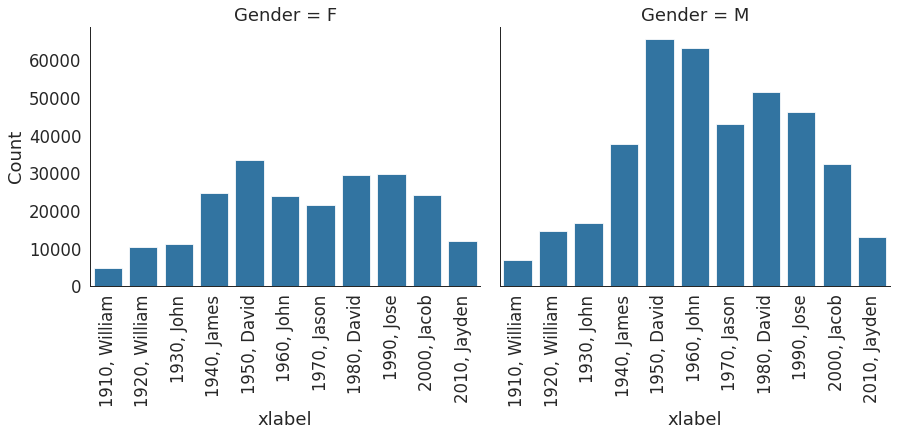

In [ ]:
# Get highest year
highest_year = c.execute("SELECT MAX(Year) FROM Names").fetchone()[0]
# Get lowest year
lowest_year = c.execute("SELECT MIN(Year) FROM Names").fetchone()[0]
# Get highest decade
highest_decade = highest_year - (highest_year % 10)
# Get lowest decade
lowest_decade = lowest_year - (lowest_year % 10)
# Define list to store most popular
most_popular = []
# Loop over male and female
for i in ["F", "M"]:
  # Loop over decades
  for j in range(lowest_decade, highest_decade + 10, 10):
    # Get third most popular
    third_most_popular = c.execute(
        "SELECT Name, SUM(Count) FROM Names WHERE State='CA' AND "
        f"Gender='{i}' AND Year>={j} AND Year<{j+10} GROUP BY Name ORDER "
        "BY SUM(Count) DESC LIMIT 3;"
    ).fetchall()[2]
    # Add to list
    most_popular.append([i, j, *third_most_popular])
# Create datframe
df = pd.DataFrame(most_popular, columns=["Gender", "Decade", "Name",
                                         "Count"]).sort_values("Decade")
"""Bonus: Visualize it somehow using Matplotlib (5pt)"""
# Create x lable
df["xlabel"] = df["Decade"].astype(str) + ", " + df["Name"]
# Create plot
g = sns.FacetGrid(df, col="Gender", height=6.4)
g.map(sns.barplot, "xlabel", "Count")
# Sort xlables
for axes in g.axes.flat:
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
# Show plot
plt.tight_layout()
plt.show()
# close the cursor
c.close()
# Close the connection
con.close()

# 2. Flavors of Cacao Dataset (15pt)

Using the [Flavors of Cacao](https://www.kaggle.com/rombikuboktaeder/choco-flavors) dataset, answer the following questions:

**Question 1:** Write a function that returns the number of bars manufactured where the bars' BroadBean Origin is a given country. Use the function to calculate the number of bars where BroadBean Origin is 'Ecuador' (15pt)

**Question 2:** Write a function that returns the maximal and average cocoa percentage in a bar manufactured by a company in a specific country. Use the function to calculate the minimal and average cocoa percentage in bars manufactured by a Swiss company (15pt).

In [ ]:
# Download csv
!kaggle datasets download rombikuboktaeder/choco-flavors -f flavors_of_cacao.csv

# Read data
flavors_of_cacao = pd.read_csv("flavors_of_cacao.csv").dropna()

# Create database
db = Database()
db.bind(
    provider='sqlite', filename='/content/flavors-of-cacao.pony.db',
    create_db=True
)


# Define entities
class ChocoFlavor(db.Entity):
  company = Required(str)
  specific_bean_origin = Required(str)
  ref = Required(int)
  review_date = Required(int)
  cocoa_percent = Required(float)
  company_location = Required(str)
  rating = Required(float)
  bean_type = Optional(str)
  broad_bean_origin = Optional(str)


# Create tables
db.generate_mapping(create_tables=True)

# Creating entity instances
for idx, row in flavors_of_cacao.iterrows():
  ChocoFlavor(
      company=row[0], specific_bean_origin=row[1], ref=row[2],
      review_date=row[3], cocoa_percent=row[4][:-1], company_location=row[5],
      rating=row[6], bean_type=row[7], broad_bean_origin=row[8]
  )
commit()


# Funnction that returns the maximal and average cocoa percentage in a bar
# manufactured by a company in a specific country
def max_avg_c_precentage(country):
  return list(
      select(
          (max(c.cocoa_percent), avg(c.cocoa_percent))
          for c in ChocoFlavor
          if c.company_location == country
      )
  )[0]


print("max = {0}, avg = {1}".format(*max_avg_c_precentage("Switzerland")))

100% 125k/125k [00:00<00:00, 244kB/s]
100% 125k/125k [00:00<00:00, 244kB/s]
max = 88.0, avg = 71.21052631578948


**Question 3:** Calculate the second most common bean type(s) and the most rare bean type(s) (15
pt)

**Question 4:** Calculate the number of reviews and the average rating in each year. Calculate the number of reviews and the average rating of each company in each year (15pt)

# 3. Kickstarter Projects Dataset (25pt)

Using the [Kickstarter Projects Dataset](https://www.kaggle.com/kemical/kickstarter-projects#ks-projects-201801.csv), answer the following questions:

**Task 1 (for everyone):** Load the dataset to SQLite DB using [PonyORM](https://ponyorm.org) (10pt)

In [ ]:
# Download Data
!kaggle datasets download -d kemical/kickstarter-projects
!unzip ./kickstarter-projects.zip

# Read data
ks = pd.read_csv("ks-projects-201801.csv", encoding="ISO-8859-1")
ks["usd pledged"].fillna(0.0, inplace=True)
ks["name"].fillna("", inplace=True)

# Create a new database
db = Database()
db.bind(
    provider='sqlite', filename='/content/kickstarter-project.pony.db',
    create_db=True
)


# Define entities
class KickstarterProject(db.Entity):
  name = Optional(str)
  category = Required(str)
  main_category = Required(str)
  currency = Required(str)
  deadline = Required(str)
  goal = Required(float)
  launched = Required(str)
  pledged = Required(float)
  launched = Required(str)
  state = Required(str)
  backers = Required(int)
  country = Required(str)
  usd_pledged = Optional(float)
  usd_pledged_real = Required(float)
  usd_goal_real = Required(float)


# Create tables
db.generate_mapping(create_tables=True)

# Creating entity instances
for idx, row in ks.iterrows():
  KickstarterProject(
      name=row[1], category=row[2], main_category=row[3], currency=row[4],
      deadline=row[5], goal=row[6], launched=row[7], pledged=row[8],
      state=row[9], backers=row[10], country=row[11], usd_pledged=row[12],
      usd_pledged_real=row[13], usd_goal_real=row[14]
  )
commit()

100% 36.8M/36.8M [00:02<00:00, 25.2MB/s]
100% 36.8M/36.8M [00:02<00:00, 14.9MB/s]
Archive:  ./kickstarter-projects.zip
  inflating: ks-projects-201612.csv  
  inflating: ks-projects-201801.csv  


### <span style="color:red"> Please answer only **one** of the following questions according to your ID number (use the formula **<YOUR_ID> mod 3 +1**) </span>

In [ ]:
# which question to answer - put your ID number and run the code 
your_id  = "208373365"
q = int(your_id) % 3 + 1
print("You need to answer question number %s" % q)

You need to answer question number 2


**Question 1:** On average which project category received the highest number of backers? (15 pt)

**Question 2:** On average which project category received the highest pledged USD? (15 pt)

In [ ]:
project_category = list(
    select((p.category, avg(p.usd_pledged)) for p in KickstarterProject
          ).sort_by(lambda x, y: desc(y))
)[0][0]
print(f"{project_category} project category received the highest pledged USD")

3D Printing project category received the highest pledged USD


**Question 3:** In which month occurred the highest number of projects? (15 pt)

## 4. Oscars Datasets (10pt)

Using the [Oscars Dataset](https://www.kaggle.com/theacademy/academy-awards), please answer only one of the following questions (you can chose):

**Question 1:** Who is the male actress with the most Oscar nominees? (10pt)

In [ ]:
# Download Data
!kaggle datasets download -d theacademy/academy-awards
!unzip academy-awards.zip

# Read data
oscar = pd.read_csv("database.csv", encoding="ISO-8859-1")
oscar["Winner"].fillna(0.0, inplace=True)
oscar["Film"].fillna("", inplace=True)

# Create a new database
db = Database()
db.bind(
    provider='sqlite', filename='/content/academy-awards.pony.db',
    create_db=True
)


# Define entities
class AcademyAwards(db.Entity):
  year = Optional(str)
  ceremony = Required(int)
  award = Required(str)
  winner = Required(float)
  name = Required(str)
  film = Optional(str)


# Create tables
db.generate_mapping(create_tables=True)

# Creating entity instances
for idx, row in oscar.iterrows():
  AcademyAwards(
      year=row[0],
      ceremony=row[1],
      award=row[2],
      winner=row[3],
      name=row[4],
      film=row[5],
  )
commit()

# Print male actress with the most Oscar nominees
most_nominees = list(
    select(
        (a.name, count(a.year)) for a in AcademyAwards if a.award == "Actor"
    ).sort_by(lambda x, y: desc(y))
)[0]
print(
    f"male actress with the most Oscar nominees is "
    "{most_nominees[0]} with {most_nominees[1]} nominees "
)

100% 185k/185k [00:00<00:00, 336kB/s]
100% 185k/185k [00:00<00:00, 336kB/s]
Archive:  academy-awards.zip
  inflating: database.csv            
male actress with the most Oscar nominees is Spencer Tracy with 9 nominees 


**Question 2:** Who is the female director with the most Oscar nominees? (10pt)

**Question 3:** Which top-10 movies received the highest number of Oscar nominees? (10pt)

**Question 4:** Write a function that receives an actor's name and returns the actor’s number of Oscar nominees. Use the function to calculate the number of times Leonardo DiCaprio was a nominee (10pt)

## 5.  Cool Bonus: LLMs & Stable Difussion (10pt)

Using GPT-2 (or any other LLM model), create a simple code that generates a bedtime story with 10-page of related images.

I asked ChatGPT to "Describe a 10 sentence be time story that includes monsters and robots" and got the following ansewer:

1. Once upon a time, in a far-off planet, there were two rival kingdoms - one ruled by robots, and the other by monsters. 

2. Both kingdoms had been at war for decades, and neither side seemed to be winning.

3. One day, the monster king decided to unleash his latest weapon - a giant, fire-breathing creature that could destroy anything in its path. 

4. The robot king, however, was not one to be outdone, and he sent his most advanced robot warriors to battle the monster.

5. The two sides clashed in a fierce battle, and it seemed like the monster would emerge victorious. 

6. But just as all hope seemed lost, the robots unleashed their secret weapon - a powerful laser beam that cut through the monster's scales like butter.

7. The monster king was furious and ordered his army to attack the robots with even greater force. But the robots were ready, and they had built a giant robot that was impervious to the monsters' attacks.

8. The giant robot crushed everything in its path, and the monster army was quickly defeated. The monster king was forced to surrender, and the two sides finally made peace.

9. In the end, the robots and monsters realized that they were not so different after all, and they decided to work together to build a better world. Together, they created a utopia where all creatures - robots and monsters alike - could live in peace and harmony. 

10. And so, the two kingdoms became one, and the planet was forever changed.

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

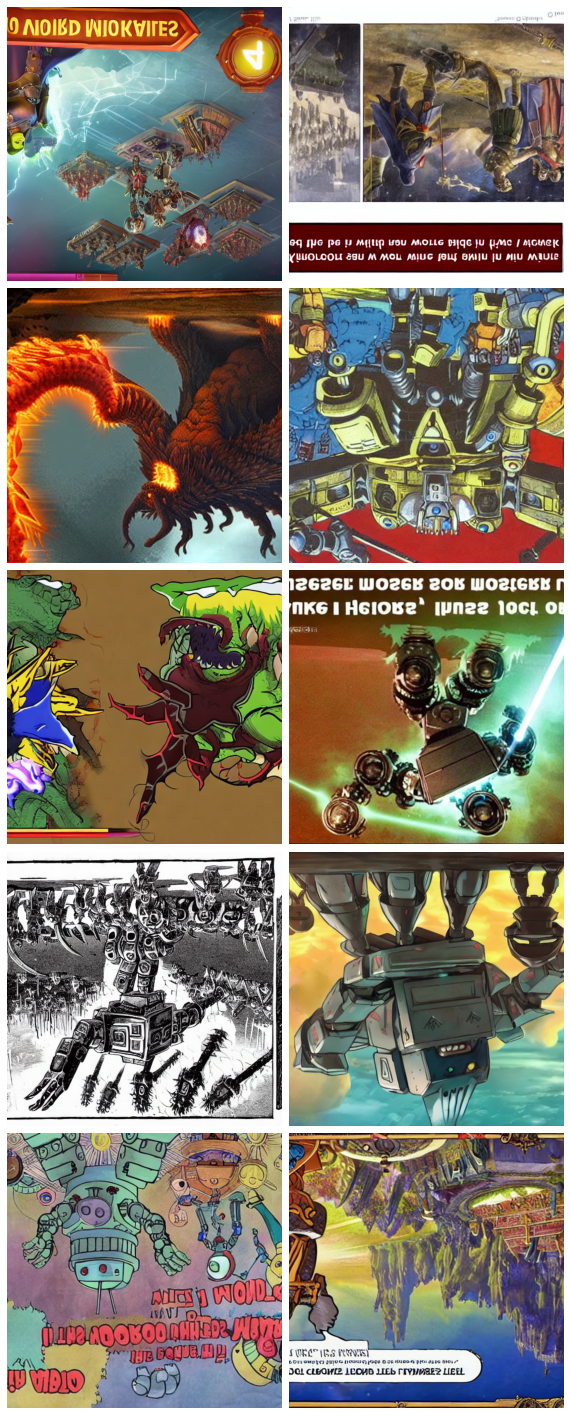

In [ ]:
# Define Diffusion pipline
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

# Define chatgpt story
chat_gpt_story = [
    "Once upon a time, in a far-off planet, there were two rival kingdoms - one ruled by robots, and the other by monsters.",
    "Both kingdoms had been at war for decades, and neither side seemed to be winning.",
    "One day, the monster king decided to unleash his latest weapon - a giant, fire-breathing creature that could destroy anything in its path.",
    "The robot king, however, was not one to be outdone, and he sent his most advanced robot warriors to battle the monster.",
    "The two sides clashed in a fierce battle, and it seemed like the monster would emerge victorious.",
    "But just as all hope seemed lost, the robots unleashed their secret weapon - a powerful laser beam that cut through the monster's scales like butter.",
    "The monster king was furious and ordered his army to attack the robots with even greater force. But the robots were ready, and they had built a giant robot that was impervious to the monsters' attacks.",
    "The giant robot crushed everything in its path, and the monster army was quickly defeated. The monster king was forced to surrender, and the two sides finally made peace.",
    "In the end, the robots and monsters realized that they were not so different after all, and they decided to work together to build a better world. Together, they created a utopia where all creatures - robots and monsters alike - could live in peace and harmony.",
    "And so, the two kingdoms became one, and the planet was forever changed."
]

# Create image for each sentence
image_list = []
for sentence in chat_gpt_story:
  image = pipe(sentence).images[0]
  image_list.append(image)

# Create figure
fig = plt.figure(figsize=(20, 20))
# Create grid
grid = ImageGrid(fig, 111, nrows_ncols=(5, 2), axes_pad=0.1)

# Iterate over the grid and images to add each image
for ax, im in zip(grid, image_list):
  ax.imshow(ImageOps.flip(im))
  ax.axis("off")

# Show grid
plt.tight_layout()
plt.show()